<a href="https://colab.research.google.com/github/URBAN-IA/URBANIA/blob/main/study/ml/Gradient_Boosting_Machine_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **<font color=white> 13.Gradient Boosting Machine Code 실습**

[목적]
  - Bias를 낮추기위한 Boosting 모델의 AdaBoost을 개선한 GBM 실습 및 해석

[Process]
  1. Define X's & Y
  2. Split Train & Valid dataset
  3. Modeling
  4. Model 해석

In [1]:
import os
import gc
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.ensemble import GradientBoostingClassifier
from collections import Counter

In [2]:
# Data Loading (수술 時 사망 데이터)
data=pd.read_csv("https://raw.githubusercontent.com/GonieAhn/Data-Science-online-course-from-gonie/main/Data%20Store/example_data.csv")

In [3]:
data.describe()

,censor,event,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,...,gender,str2,strat,symptom,cd40,cd420,cd496,r,cd80,cd820
count,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,...,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000
mean,0.340226,801.236842,35.225564,76.061855,0.078947,0.640977,0.118421,95.432331,0.030075,0.546992,...,0.812030,0.580827,1.981203,0.167293,353.204887,336.139098,173.146617,0.603383,987.250000,928.214286
std,0.474231,326.887929,8.852094,13.224698,0.269910,0.480165,0.323410,5.981856,0.170955,0.498255,...,0.391056,0.493888,0.905946,0.373589,114.105253,130.961573,191.455406,0.489656,475.223907,438.569798
min,0.000000,33.000000,13.000000,47.401000,0.000000,0.000000,0.000000,70.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,103.000000,49.000000,-1.000000,0.000000,221.000000,150.000000
25%,0.000000,535.750000,29.000000,67.500000,0.000000,0.000000,0.000000,90.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,271.000000,243.750000,-1.000000,0.000000,653.250000,626.500000
50%,0.000000,933.500000,34.000000,74.600000,0.000000,1.000000,0.000000,100.000000,0.000000,1.000000,...,1.000000,1.000000,2.000000,0.000000,346.000000,330.500000,113.000000,1.000000,881.000000,818.000000
75%,1.000000,1081.000000,40.000000,83.502000,0.000000,1.000000,0.000000,100.000000,0.000000,1.000000,...,1.000000,1.000000,3.000000,0.000000,422.000000,418.000000,324.000000,1.000000,1190.000000,1164.000000
max,1.000000,1231.000000,70.000000,149.000000,1.000000,1.000000,1.000000,100.000000,1.000000,1.000000,...,1.000000,1.000000,3.000000,1.000000,771.000000,909.000000,857.000000,1.000000,4255.000000,3130.000000


In [4]:
# X's & Y Split
Y = data['censor']
X = data.drop(columns=['censor'])

In [5]:
idx = list(range(X.shape[0]))
train_idx, valid_idx = train_test_split(idx, test_size=0.3, random_state=2021)
print(">>>> # of Train data : {}".format(len(train_idx)))
print(">>>> # of valid data : {}".format(len(valid_idx)))
print(">>>> # of Train data Y : {}".format(Counter(Y.iloc[train_idx])))
print(">>>> # of valid data Y : {}".format(Counter(Y.iloc[valid_idx])))

>>>> # of Train data : 372
>>>> # of valid data : 160
>>>> # of Train data Y : Counter({0: 241, 1: 131})
>>>> # of valid data Y : Counter({0: 110, 1: 50})


[Gradient Boosting Machine Parameters]
  - Package : https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
  - n_estimators : # of Tree
  - learning_rate : learning_rate과 n_estimator와 Trade-off 관계가 있음
    - Weight applied to each classifier at each boosting iteration
  - max_features : Feature 수 sampling (Overfitting 방지)
  - subsample : Data Subsample (Overfitting 방지, Bootstrap X)
  - max_depth : Tree의 최대 깊이 제한

In [ ]:
# GBM Hyperparameter
estimators = [10, 20, 50]
learning = [0.05, 0.1, 0.5]
subsam = [0.5, 0.75, 1]

# Modeling
save_est = []
save_lr = []
save_sub = []
f1_score_ = []

cnt = 0
for est in estimators:
    for lr in learning:
        for sub in subsam:
            print(">>> {} <<<".format(cnt))
            cnt += 1
            print("Number of Estimators : {}, Learning Rate : {}, Subsample : {}".format(est, lr, sub))

            model = GradientBoostingClassifier(n_estimators=est,
                                               learning_rate=lr,
                                               subsample=sub,
                                               random_state=119)
            model.fit(X.iloc[train_idx], Y.iloc[train_idx])

            # Train Acc
            y_pre_train = model.predict(X.iloc[train_idx])
            cm_train = confusion_matrix(Y.iloc[train_idx], y_pre_train)
            print("Train Confusion Matrix")
            print(cm_train)
            print("Train Acc : {}".format((cm_train[0,0] + cm_train[1,1])/cm_train.sum()))
            print("Train F1-Score : {}".format(f1_score(Y.iloc[train_idx], y_pre_train)))

            # Test Acc
            y_pre_test = model.predict(X.iloc[valid_idx])
            cm_test = confusion_matrix(Y.iloc[valid_idx], y_pre_test)
            print("Test Confusion Matrix")
            print(cm_test)
            print("TesT Acc : {}".format((cm_test[0,0] + cm_test[1,1])/cm_test.sum()))
            print("Test F1-Score : {}".format(f1_score(Y.iloc[valid_idx], y_pre_test)))
            print("-----------------------------------------------------------------------")
            print("-----------------------------------------------------------------------")
            save_est.append(est)
            save_lr.append(lr)
            save_sub.append(sub)
            f1_score_.append(f1_score(Y.iloc[valid_idx], y_pre_test))

>>> 0 <<<
Number of Estimators : 10, Learning Rate : 0.05, Subsample : 0.5
Train Confusion Matrix
[[240   1]
 [ 51  80]]
Train Acc : 0.8602150537634409
Train F1-Score : 0.7547169811320754
Test Confusion Matrix
[[102   8]
 [ 12  38]]
TesT Acc : 0.875
Test F1-Score : 0.7916666666666667
-----------------------------------------------------------------------
-----------------------------------------------------------------------
>>> 1 <<<
Number of Estimators : 10, Learning Rate : 0.05, Subsample : 0.75
Train Confusion Matrix
[[240   1]
 [ 53  78]]
Train Acc : 0.8548387096774194
Train F1-Score : 0.7428571428571428
Test Confusion Matrix
[[105   5]
 [ 13  37]]
TesT Acc : 0.8875
Test F1-Score : 0.8043478260869565
-----------------------------------------------------------------------
-----------------------------------------------------------------------
>>> 2 <<<
Number of Estimators : 10, Learning Rate : 0.05, Subsample : 1
Train Confusion Matrix
[[237   4]
 [ 40  91]]
Train Acc : 0.8817204

In [ ]:
print(">>> {} <<<\nBest Test f1-score : {}\nBest n_estimators : {}\nBest SubSampling : {}\nBest Learning Rate : {}".format(np.argmax(f1_score_),
                                                                                                                           f1_score_[np.argmax(f1_score_)],
                                                                                                                           save_est[np.argmax(f1_score_)],
                                                                                                                           save_sub[np.argmax(f1_score_)],
                                                                                                                           save_lr[np.argmax(f1_score_)]))

In [ ]:
best_model = GradientBoostingClassifier(n_estimators=save_est[np.argmax(f1_score_)],
                                        learning_rate=save_lr[np.argmax(f1_score_)],
                                        subsample = save_sub[np.argmax(f1_score_)],
                                        random_state=119)
best_model.fit(X.iloc[train_idx], Y.iloc[train_idx])

# Train Acc
y_pre_train = best_model.predict(X.iloc[train_idx])
cm_train = confusion_matrix(Y.iloc[train_idx], y_pre_train)
print("Train Confusion Matrix")
print(cm_train)
print("Train Acc : {}".format((cm_train[0,0] + cm_train[1,1])/cm_train.sum()))
print("Train F1-Score : {}".format(f1_score(Y.iloc[train_idx], y_pre_train)))

# Test Acc
y_pre_test = best_model.predict(X.iloc[valid_idx])
cm_test = confusion_matrix(Y.iloc[valid_idx], y_pre_test)
print("Test Confusion Matrix")
print(cm_test)
print("TesT Acc : {}".format((cm_test[0,0] + cm_test[1,1])/cm_test.sum()))
print("Test F1-Score : {}".format(f1_score(Y.iloc[valid_idx], y_pre_test)))

In [ ]:
feature_map = pd.DataFrame(sorted(zip(best_model.feature_importances_, X.columns), reverse=True), columns=['Score', 'Feature'])
print(feature_map)

In [ ]:
# Importance Score Top 10
feature_map_20 = feature_map.iloc[:10]
plt.figure(figsize=(20, 10))
sns.barplot(x="Score", y="Feature", data=feature_map_20.sort_values(by="Score", ascending=False), errwidth=40)
plt.title('Gradient Boosting Machine Importance Features')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# Data Loading (당뇨병)
data = pd.read_csv('https://www4.stat.ncsu.edu/~boos/var.select/diabetes.tab.txt', sep='\t')

In [ ]:
# X's & Y Split
Y = data['Y']
X = data.drop(columns=['Y'])
X = pd.get_dummies(X, columns=['SEX'])
idx = list(range(X.shape[0]))
train_idx, valid_idx = train_test_split(idx, test_size=0.3, random_state=2023)
print(">>>> # of Train data : {}".format(len(train_idx)))
print(">>>> # of valid data : {}".format(len(valid_idx)))

In [ ]:
# GBM Hyperparameter
estimators = [70, 90, 120]
learning = [0.05, 0.1, 0.5]
subsam = [0.5, 0.75, 1]

# Modeling
save_est = []
save_lr = []
save_sub = []

cnt = 0
for est in estimators:
    for lr in learning:
        for sub in subsam:
            print(">>> {} <<<".format(cnt))
            cnt += 1
            print("Number of Estimators : {}, Learning Rate : {}, Subsample : {}".format(est, lr, sub))

            model = GradientBoostingRegressor(n_estimators=est,
                                               learning_rate=lr,
                                               subsample=sub,
                                               random_state=119)
            model.fit(X.iloc[train_idx], Y.iloc[train_idx])

            # Train Acc
            y_pre_train = model.predict(X.iloc[train_idx])
            rmse_train = np.sqrt(mean_squared_error(Y.iloc[train_idx], y_pre_train))
            print("Train RMSE : {}".format(np.sqrt(mean_squared_error(Y.iloc[train_idx], y_pre_train))))
            print("Train R2 : {}".format(r2_score(Y.iloc[train_idx], y_pre_train)))

            # Test Acc
            y_pre_test = model.predict(X.iloc[valid_idx])
            print("TesT RMSE : {}".format(np.sqrt(mean_squared_error(Y.iloc[valid_idx], y_pre_test))))
            print("Test R2 : {}".format(r2_score(Y.iloc[valid_idx], y_pre_test)))
            print("-----------------------------------------------------------------------")
            print("-----------------------------------------------------------------------")

[ElasticNet Result]

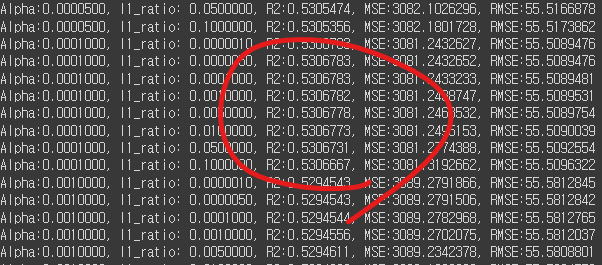